In [1]:
from __future__ import division, print_function, absolute_import
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import cv2
import os
import sys
from PIL import Image
from timeit import time

from stereo_reconstruction import structure
from stereo_reconstruction import processor
from stereo_reconstruction.features import match_images

from yolo3_deepsort.yolo import YOLO
from yolo3_deepsort.deep_sort.detection import Detection
from yolo3_deepsort.deep_sort.tracker import Tracker
from yolo3_deepsort.tools import generate_detections as gdet
from yolo3_deepsort.tools.plot_utils import draw_one_box as draw_box
from yolo3_deepsort.deep_sort.detection import Detection as ddet

Using TensorFlow backend.


# Create Components

In [2]:
# create yolov3 detector
# yolo = YOLO(model_path = 'yolo3_deepsort/model_data/yolo_ori.h5',
#             classes_path = 'yolo3_deepsort/model_data/coco_classes.txt',
#             weights_only = True,
#             score = 0.3,
#             iou = 0.5) # coco version
yolo = YOLO(model_path = 'yolo3_deepsort/model_data/trained_weights_coco.h5',
            classes_path = 'yolo3_deepsort/model_data/classes_name.txt',
            weights_only = True,
            score = 0.3,
            iou = 0.5) # our version

# create feature encoder
model_filename = 'yolo3_deepsort/model_data/mars-small128.pb'
encoder = gdet.create_box_encoder(model_filename,batch_size=1)

# create tracker
nms_max_overlap = 1.0# SORT
max_distance = 0.3
lambda0 = 1
nn_budget = None
tracker = Tracker(metric_mode="cosine",max_cosine_distance=max_distance,
                      lambda0 = lambda0,nn_budget=nn_budget)

yolo3_deepsort/model_data/trained_weights_coco.h5 model, anchors, and classes loaded.


# Detection Tracking and Matching

In [4]:
import time
video_path = r"G:\binocular_video\20191022_022500_video.h265"
cap = cv2.VideoCapture(video_path)
w = int(cap.get(3))
h = int(cap.get(4))
fps = cap.get(5)

write_flag = True
if write_flag:
    out = cv2.VideoWriter('result/road_test_BBA.avi',cv2.VideoWriter_fourcc(*'XVID'), fps, (w//2,2*h))
fontsize = 25

In [5]:
while cap.isOpened():
    toi = time.time()
    # read video
    ret,frame = cap.read()
    
    if ret != True:
        break# it's really really really important!!!
        
    frame_left = frame[:,:w//2,:]
    frame_right = frame[:,w//2:,:]
    img_left_pil = Image.fromarray(frame_left.copy()[...,::-1])
    img_right_pil = Image.fromarray(frame_right.copy()[...,::-1])
    
    # detection
    boxes,classes,scores = yolo.detect_image(img_left_pil)
    
    # encoder features
    features = encoder(frame_left,boxes)
    detections = [Detection(bbox, score, feature,class_)
                    for bbox,score,feature,class_ in zip(boxes,scores,features,classes)]
    
    # call the tracker
    tracker.predict()
    tracker.update(detections)
    
    print("fps:%f"%(1/(time.time()-toi)))
    
    # Visualize result++++++++++++++++++
    img_left_draw = img_left_pil.copy()
    img_right_draw = img_right_pil.copy()
    for i,track in enumerate(tracker.tracks):
        if not track.is_confirmed() or track.time_since_update > 1:
            continue
        
        # track.to_tlbr() actually get ltrb && track.to_tlwh() actually get ltwh 
        bbox = track.to_tlbr()
        _,_,bbox_matched = match_images(frame_left,frame_right,track.to_tlwh().astype(int),
                                        offset=(-400,-40,0,40),method = cv2.TM_CCOEFF_NORMED)# match two image
        
        # property of the object
        object_id = track.track_id
        object_class = track.object_class
        color = yolo.colors[yolo.class_names.index(object_class)]
        # draw boxes
        img_left_draw = draw_box(img_left_draw,bbox,object_id,object_class,color,fontsize)
        img_right_draw = draw_box(img_right_draw,bbox_matched,object_id,object_class,color,fontsize)
        
    img_left_show = np.asarray(img_left_draw)
    img_right_show = np.asarray(img_right_draw)
    img_show = np.concatenate((img_left_show,img_right_show),axis = 0)
    
    if write_flag:
        out.write(img_show[...,::-1])# save result
    cv2.imshow('demo',cv2.resize(img_show[...,::-1],(int(w/2.5),int(h/1.5))))
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
if write_flag:
    out.release()
cap.release()
cv2.destroyAllWindows()

fps:0.198167
fps:4.850415
fps:5.969817
fps:5.898266
fps:5.567241
fps:6.179526
fps:6.289066
fps:5.787762
fps:6.216888
fps:6.272813
fps:6.257549
fps:5.682985
fps:6.197835
fps:5.695819
fps:6.171661
fps:5.652427
fps:5.995443
fps:5.925933
fps:6.259632
fps:6.250164
fps:5.753046
fps:5.916003
fps:6.372589
fps:6.270525
fps:6.021661
fps:5.750711
fps:6.390629
fps:6.258530
fps:6.308865
fps:6.395579
fps:6.354477
fps:6.244841
fps:6.298454
fps:6.016108
fps:6.416861
fps:6.278992
fps:6.284957
fps:6.584031
fps:6.057955
fps:6.012098
fps:6.391622
fps:6.386104
fps:5.949646
fps:6.041246
fps:6.042821
fps:5.695966
fps:5.997338
fps:5.937694
fps:5.697064
fps:5.655536
fps:5.605612
fps:5.739277
fps:6.314184
fps:6.316970
fps:6.321350
fps:5.948768
fps:6.642800
fps:6.001594
fps:4.925754
fps:6.185103
fps:6.019752
fps:6.356441
fps:6.318864
fps:6.261361
fps:5.971143
fps:5.922176
fps:6.198677
fps:6.424380
fps:6.263296
fps:5.844392
fps:5.639908
fps:6.019078
fps:5.265436
fps:5.970310
fps:5.903704
fps:6.407646
fps:6.403175

fps:5.993892
fps:6.403185
fps:6.401338
fps:5.824767
fps:6.021748
fps:6.401514
fps:6.407949
fps:6.194045
fps:6.407920
fps:6.403254
fps:5.819716
fps:5.879679
fps:6.401602
fps:5.819667
fps:6.055664
fps:6.074766
fps:5.823659
fps:5.748063
fps:6.106819
fps:5.781029
fps:5.818408
fps:5.735377
fps:5.824112
fps:6.407930
fps:6.232972
fps:5.823910
fps:5.819659
fps:5.881377
fps:5.820733
fps:6.403205
fps:6.403195
fps:5.960832
fps:5.824953
fps:6.407900
fps:6.056145
fps:6.097772
fps:6.406491
fps:5.884389
fps:5.823740
fps:6.403205
fps:6.070440
fps:5.755019
fps:5.822810
fps:6.407891
fps:6.106784
fps:6.407920
fps:6.403664
fps:5.882730
fps:6.092449
fps:6.034640
fps:6.256187
fps:5.870774
fps:6.359342
fps:6.406511
fps:5.883431
fps:6.120480
fps:6.406677
fps:5.960231
fps:6.400088
fps:6.403615
fps:6.296695
fps:6.000289
fps:5.824832
fps:5.820669
fps:6.062237
fps:5.821428
fps:6.106544
fps:6.051505
fps:6.070695
fps:5.775186
fps:6.173151
fps:5.824023
fps:5.819756
fps:5.724293
fps:5.820887
fps:6.351917
fps:5.587473

fps:5.278610
fps:5.486903
fps:5.427159
fps:5.309931
fps:5.334561
fps:5.334683
fps:5.292758
fps:5.038947
fps:5.256251
fps:5.334609
fps:4.000984
fps:5.143981
fps:5.333625
fps:5.019866
fps:5.334561
fps:5.485045
fps:5.819554
fps:4.924568
fps:4.995479
fps:4.572505
fps:5.334520
fps:5.383055
fps:4.924273
fps:4.683255
fps:4.924216
fps:5.334588
fps:5.179956
fps:4.924216
fps:4.726040
fps:5.334568
fps:4.573128
fps:5.577510
fps:4.924250
fps:5.759959
fps:5.334853
fps:5.819611
fps:5.420909
fps:5.776498
fps:5.819578
fps:5.489855
fps:5.777883
fps:5.335457
fps:5.421288
fps:5.818472
fps:5.537744
fps:5.819554
fps:5.334527
fps:5.523538
fps:5.778408
fps:5.577992
fps:5.572300
fps:5.778154
fps:5.335579
fps:5.512170
fps:5.820693
fps:5.766952
fps:5.449172
fps:5.818626
fps:5.821525
fps:5.691266
fps:5.778560
fps:5.775504
fps:5.666569
fps:5.708563
fps:5.775043
fps:5.836065
fps:5.249054
fps:5.777843
fps:6.117874
fps:5.626094
fps:5.820653
fps:5.777907
fps:5.755319
fps:5.777899
fps:6.352013
fps:5.762697
fps:6.348090

fps:5.820410
fps:5.810927
fps:6.349849
fps:5.823352
fps:5.925581
fps:5.820402
fps:5.824767
fps:5.833784
fps:5.809583
fps:5.824532
fps:5.702672
fps:5.825422
fps:5.819837
fps:5.829843
fps:5.830848
fps:6.054204
fps:5.823716
fps:5.820144
fps:6.036333
fps:6.408037
fps:5.821372
fps:5.897801
fps:5.820192
fps:6.088788
fps:5.687608
fps:5.822317
fps:5.824613
fps:5.571220
fps:5.823813
fps:5.823554
fps:5.796768
fps:5.824953
fps:5.600291
fps:5.824953
fps:5.525888
fps:5.552229
fps:5.824921
fps:6.041315
fps:5.784457
fps:5.824055
fps:5.739694
fps:5.825002
fps:5.572293
fps:5.659016
fps:5.825091
fps:5.739835
fps:5.825042
fps:5.777207
fps:5.907054
fps:5.824985
fps:5.819934
fps:6.092272
fps:5.820216
fps:6.026282
fps:5.821380
fps:5.820394
fps:5.747299
fps:5.825074
fps:5.824977
fps:5.802245
fps:5.541022
fps:5.874589
fps:5.824759
fps:5.823788
fps:5.611762
fps:5.825042
fps:5.825074
fps:5.495429
fps:5.824274
fps:5.736193
fps:5.825139
fps:5.825034
fps:5.587578
fps:5.569193
fps:5.825123
fps:5.825034
fps:5.334738

fps:5.759041
fps:6.074018
fps:6.407969
fps:6.029660
fps:6.403205
fps:6.402911
fps:6.401563
fps:5.688727
fps:6.403215
fps:6.401817
fps:6.100415
fps:6.408174
fps:6.355083
fps:5.745236
fps:5.824201
fps:5.779985
fps:6.408165
fps:5.932437
fps:5.824265
fps:6.408498
fps:6.043953
fps:6.406794
fps:6.408351
fps:5.877907
fps:6.407421
fps:6.407940
fps:6.408194
fps:6.031290
fps:6.114556
fps:6.401514
fps:6.089477
fps:6.407979
fps:6.086349
fps:6.287511
fps:6.313291
fps:6.400137
fps:6.408155
fps:6.097125
fps:6.403527
fps:6.403635
fps:6.403185
fps:5.882573
fps:6.109577
fps:6.407861
fps:5.970157
fps:6.408253
fps:6.408008
fps:6.401534
fps:5.984621
fps:6.097365
fps:6.356624
fps:6.395833
fps:6.407802
fps:6.401319
fps:6.406941
fps:5.768705
fps:6.120972
fps:6.401494
fps:6.038880
fps:6.403645
fps:6.407842
fps:6.408478
fps:5.951782
fps:6.116919
fps:6.407900
fps:5.977381
fps:6.407988
fps:6.408037
fps:6.408165
fps:6.000332
fps:6.700755
fps:6.407910
fps:6.060213
fps:6.403136
fps:6.403263
fps:6.403234
fps:6.399151

fps:6.060292
fps:6.402784
fps:6.403713
fps:6.272419
fps:5.849690
fps:5.822988
fps:5.824840
fps:5.946221
fps:6.092139
fps:6.399990
fps:5.999079
fps:6.408194
fps:6.407861
fps:6.408057
fps:6.430733
fps:6.407685
fps:6.407744
fps:6.189685
fps:6.350830
fps:6.406569
fps:5.820976
fps:5.778026
fps:5.932512
fps:6.403195
fps:5.813803
fps:6.100016
fps:6.355256
fps:6.349484
fps:5.974554
fps:6.402863
fps:6.407802
fps:5.912634
fps:6.350888
fps:6.403664
fps:6.401524
fps:5.916904
fps:6.089849
fps:6.280675
fps:6.025857
fps:6.407754
fps:6.407881
fps:6.403713
fps:5.986330
fps:6.038915
fps:6.408439
fps:5.993918
fps:6.402824
fps:6.082395
fps:6.358812
fps:6.016142
fps:6.710328
fps:6.407019
fps:5.824678
fps:6.068693
fps:6.355045
fps:6.402990
fps:6.192975
fps:6.300421
fps:6.354496
fps:6.339311
fps:6.408067
fps:5.778998
fps:5.824354
fps:5.883233
fps:5.819530
fps:6.092591
fps:5.855611
fps:5.824961
fps:5.821307
fps:6.406462
fps:5.882928
fps:6.402921
fps:6.407891
fps:5.994560
fps:5.819538
fps:6.408077
fps:5.836536

fps:6.402521
fps:6.406648
fps:6.408488
fps:6.408018
fps:6.065191
fps:6.358783
fps:6.408615
fps:6.408028
fps:6.396242
fps:5.819691
fps:6.401661
fps:6.408184
fps:6.408126
fps:6.083286
fps:6.406559
fps:5.801539
fps:6.097746
fps:5.832762
fps:6.408537
fps:6.401553
fps:6.403713
fps:6.406843
fps:6.108047
fps:6.087542
fps:6.166172
fps:6.401524
fps:6.291651
fps:6.406941
fps:6.407949
fps:6.356393
fps:6.106730
fps:6.073790
fps:6.408008
fps:6.157997
fps:6.408116
fps:6.406882
fps:6.408174
fps:6.403156
fps:6.408047
fps:6.408165
fps:5.933830
fps:6.408028
fps:5.828596
fps:6.408194
fps:6.297139
fps:6.403938
fps:6.401680
fps:6.407430
fps:6.402266
fps:6.096319
fps:6.097187
fps:6.406520
fps:6.354929
fps:6.317180
fps:6.408126
fps:6.408057
fps:5.817988
fps:6.406012
fps:6.049462
fps:6.363095
fps:6.407998
fps:6.407470
fps:6.387972
fps:6.403645
fps:6.403195
fps:6.075426
fps:5.820192
fps:6.098588
fps:5.819167
fps:6.122419
fps:6.403215
fps:6.396106
fps:5.819344
fps:5.786556
fps:5.820992
fps:5.819159
fps:6.124752

fps:5.821291
fps:5.825026
fps:6.093228
fps:5.825382
fps:6.129156
fps:5.823861
fps:5.825058
fps:5.823796
fps:6.027719
fps:5.780670
fps:5.819990
fps:5.819530
fps:5.823109
fps:6.086517
fps:5.820039
fps:5.595449
fps:5.824848
fps:5.651056
fps:5.732406
fps:6.100531
fps:5.824848
fps:5.776427
fps:5.820265
fps:5.820984
fps:5.820959
fps:5.818537
fps:6.130545
fps:5.825042
fps:6.169872
fps:5.713789
fps:6.100061
fps:5.819062
fps:5.736483
fps:5.824937
fps:5.824314
fps:5.657413
fps:5.824144
fps:5.824993
fps:5.825091
fps:6.057255
fps:5.824904
fps:5.557195
fps:5.823861
fps:5.556304
fps:5.573959
fps:5.824969
fps:5.824937
fps:5.824888
fps:5.818545
fps:5.777788
fps:5.824880
fps:5.769085
fps:5.824880
fps:5.737440
fps:5.820903
fps:5.825260
fps:5.825463
fps:5.817835
fps:6.071882
fps:5.825374
fps:5.551686
fps:5.824993
fps:6.077433
fps:5.819586
fps:5.781037
fps:5.824921
fps:5.714287
fps:5.819344
fps:5.824160
fps:5.825325
fps:5.820943
fps:6.090936
fps:5.825123
fps:6.076447
fps:5.819482
fps:6.061606
fps:5.824921

fps:5.820943
fps:5.819829
fps:5.764004
fps:5.820152
fps:5.780925
fps:5.665031
fps:5.825519
fps:6.122625
fps:5.820911
fps:5.706606
fps:5.819877
fps:5.829098
fps:6.096939
fps:5.819651
fps:5.704875
fps:5.570295
fps:5.694836
fps:5.825066
fps:5.825018
fps:6.074071
fps:5.820426
fps:5.747701
fps:5.824961
fps:5.489539
fps:6.118686
fps:5.825002
fps:5.825034
fps:5.821210
fps:6.108127
fps:6.153137
fps:5.802920
fps:5.654377
fps:5.779690
fps:5.816641
fps:5.825139
fps:5.825058
fps:5.643354
fps:5.820200
fps:5.749245
fps:5.777350
fps:5.825220
fps:5.571930
fps:5.824888
fps:5.592733
fps:5.819756
fps:5.736601
fps:5.824913
fps:5.750017
fps:5.821105
fps:5.821380
fps:5.548814
fps:5.697087
fps:5.585755
fps:5.824524
fps:5.750049
fps:5.777995
fps:5.824961
fps:5.580426
fps:5.780447
fps:5.714630
fps:5.824104
fps:5.818569
fps:5.580879
fps:5.824993
fps:5.751381
fps:5.824985
fps:5.782655
fps:5.476980
fps:5.782001
fps:5.742067
fps:5.825034
fps:5.823279
fps:5.530012
fps:5.824937
fps:5.646970
fps:5.825382
fps:5.824524

fps:5.839957
fps:5.825115
fps:5.825357
fps:5.790638
fps:5.825438
fps:5.824557
fps:5.811893
fps:5.825058
fps:6.401827
fps:5.812514
fps:5.819562
fps:5.821412
fps:5.823384
fps:5.824993
fps:5.824888
fps:5.782718
fps:6.358648
fps:5.824136
fps:6.258885
fps:5.767324
fps:5.819457
fps:6.402462
fps:5.758630
fps:6.106659
fps:5.824824
fps:6.034206
fps:5.825349
fps:5.824921
fps:5.775250
fps:5.824880
fps:5.818585
fps:6.286248
fps:5.999225
fps:5.824904
fps:6.401494
fps:5.944957
fps:6.114511
fps:5.824913
fps:6.043352
fps:5.824969
fps:5.824241
fps:5.930298
fps:5.824824
fps:6.407705
fps:6.407998
fps:5.877067
fps:6.103185
fps:6.400410
fps:6.038915
fps:6.403811
fps:5.824961
fps:6.059758
fps:5.891125
fps:6.407479
fps:6.407538
fps:5.818674
fps:6.088019
fps:5.824969
fps:5.742381
fps:6.359246
fps:6.079829
fps:5.845761
fps:5.820927
fps:5.820951
fps:5.773159
fps:5.901096
fps:6.406520
fps:5.818795
fps:6.300933
fps:5.819982
fps:5.824993
fps:5.718658
fps:6.611544
fps:6.351946
fps:6.408282
fps:6.254181
fps:6.401739

fps:6.407998
fps:6.403694
fps:6.401651
fps:6.080420
fps:6.101250
fps:6.403185
fps:6.281606
fps:6.068991
fps:6.121740
fps:6.407842
fps:6.042238
fps:6.408037
fps:6.407900
fps:6.401602
fps:6.393941
fps:6.401563
fps:6.400723
fps:6.408341
fps:5.956109
fps:6.722945
fps:6.407842
fps:6.079856
fps:6.353148
fps:6.406794
fps:6.401436
fps:6.153272
fps:6.407812
fps:6.401465
fps:6.399473
fps:6.408586
fps:6.406452
fps:6.407881
fps:6.403576
fps:6.157626
fps:6.711917
fps:6.403205
fps:6.195445
fps:6.362101
fps:6.407969
fps:6.401260
fps:6.195088
fps:6.718755
fps:6.407440
fps:6.401573
fps:6.054781
fps:6.407000
fps:6.402804
fps:6.407900
fps:6.401377
fps:6.406569
fps:6.408126
fps:6.403107
fps:6.068930
fps:6.666217
fps:6.407998
fps:6.160231
fps:6.278419
fps:6.406383
fps:6.401553
fps:6.079459
fps:6.718583
fps:6.353254
fps:6.407049
fps:6.201904
fps:6.408312
fps:6.110592
fps:6.355632
fps:6.149050
fps:6.407812
fps:6.407264
fps:6.401602
fps:6.181029
fps:6.156478
fps:6.407998
fps:6.407949
fps:6.219294
fps:6.732754

fps:6.042795
fps:6.301832
fps:6.407881
fps:6.402843
fps:6.086429
fps:6.407920
fps:6.401524
fps:6.401475
fps:6.043074
fps:6.407940
fps:6.401612
fps:6.401661
fps:6.455099
fps:6.400186
fps:6.406824
fps:6.107611
fps:6.268801
fps:6.702972
fps:6.401582
fps:6.253883
fps:6.131109
fps:6.726028
fps:6.408008
fps:5.886486
fps:6.347178
fps:6.406618
fps:6.407812
fps:6.003819
fps:6.406530
fps:5.820079
fps:6.406285
fps:6.446676
fps:6.406569
fps:6.402003
fps:6.077143
fps:5.986005
fps:6.098012
fps:6.407871
fps:6.250341
fps:6.045321
fps:6.721436
fps:6.407920
fps:5.941100
fps:6.407988
fps:6.401661
fps:6.407382
fps:6.397550
fps:6.407891
fps:6.401534
fps:6.408165
fps:5.935367
fps:6.125960
fps:6.403723
fps:5.987612
fps:6.406873
fps:6.407881
fps:6.401602
fps:6.021921
fps:6.400059
fps:6.401563
fps:6.407871
fps:6.141559
fps:6.766447
fps:6.408008
fps:6.080508
fps:6.402306
fps:6.403674
fps:6.403215
fps:6.365567
fps:6.408077
fps:6.402902
fps:6.407930
fps:6.109177
fps:6.115314
fps:6.400254
fps:6.232490
fps:6.336850

fps:5.821299
fps:5.556930
fps:5.825042
fps:5.820233
fps:5.671895
fps:5.298662
fps:5.820144
fps:5.275330
fps:5.824791
fps:5.823158
fps:5.833784
fps:5.576879
fps:5.818666
fps:5.607043
fps:5.824686
fps:5.819538
fps:5.308728
fps:5.824985
fps:5.824888
fps:5.870084
fps:5.820701
fps:5.821299
fps:5.774248
fps:5.820959
fps:5.824961
fps:5.814617
fps:5.569075
fps:5.824686
fps:6.148635
fps:5.824913
fps:6.399980
fps:5.709107
fps:5.821339
fps:5.821428
fps:5.575004
fps:5.820443
fps:5.824945
fps:5.639378
fps:5.781324
fps:5.819691
fps:5.626359
fps:5.709682
fps:5.781475
fps:5.533288
fps:5.824751
fps:6.407832
fps:5.921432
fps:5.824993
fps:5.821000
fps:5.559508
fps:5.571301
fps:5.820927
fps:5.913884
fps:5.820507
fps:5.820087
fps:5.716328
fps:5.820386
fps:5.820927
fps:5.820539
fps:5.767673
fps:5.819506
fps:5.823845
fps:5.385861
fps:5.821307
fps:5.824791
fps:5.913334
fps:5.819562
fps:5.820943
fps:5.651749
fps:5.824039
fps:5.821299
fps:5.473613
fps:6.086755
fps:5.813424
fps:5.424871
fps:5.824977
fps:5.821436

fps:5.402399
fps:5.825131
fps:5.787322
fps:5.824985
fps:5.824929
fps:5.551171
fps:5.820935
fps:6.068833
fps:5.561329
fps:5.820483
fps:5.759563
fps:5.824031
fps:5.782240
fps:5.692108
fps:5.818416
fps:5.572774
fps:5.825018
fps:5.727905
fps:5.825010
fps:5.825018
fps:5.824953
fps:5.821654
fps:5.599506
fps:5.824961
fps:5.548931
fps:5.824969
fps:5.717497
fps:5.819619
fps:5.338187
fps:5.824241
fps:5.824937
fps:5.825180
fps:5.823675
fps:5.567921
fps:5.819578
fps:5.587005
fps:5.575901
fps:5.823958
fps:5.824945
fps:5.760592
fps:5.825115
fps:5.824079
fps:5.575686
fps:5.824961
fps:5.823813
fps:5.820887
fps:5.821266
fps:6.040985
fps:5.824419
fps:5.631541
fps:5.820919
fps:5.736004
fps:5.929963
fps:5.819490
fps:6.086967
fps:5.824985
fps:5.806647
fps:5.821355
fps:5.821363
fps:5.518400
fps:5.819288
fps:5.765184
fps:5.820071
fps:5.824969
fps:5.590221
fps:5.823966
fps:5.824993
fps:5.337752
fps:5.785718
fps:5.338370
fps:5.824985
fps:5.558631
fps:5.339131
fps:5.701013
fps:5.339192
fps:5.338180
fps:5.567204

fps:5.830654
fps:6.406511
fps:5.824913
fps:5.820838
fps:6.100327
fps:5.824799
fps:6.090193
fps:6.399990
fps:6.403557
fps:5.883076
fps:6.401797
fps:6.407059
fps:6.403205
fps:5.911225
fps:6.056897
fps:6.074669
fps:5.877330
fps:6.403684
fps:6.403351
fps:6.403185
fps:5.916487
fps:6.406608
fps:6.408331
fps:6.006244
fps:6.406736
fps:6.406961
fps:5.794006
fps:5.824961
fps:5.824759
fps:6.406804
fps:5.737111
fps:6.022621
fps:5.825082
fps:6.130204
fps:5.819538
fps:5.823392
fps:5.764408
fps:6.317446
fps:5.819829
fps:6.401534
fps:5.972461
fps:6.399570
fps:6.401622
fps:6.650046
fps:6.407910
fps:6.406814
fps:6.406559
fps:6.047692
fps:6.133090
fps:6.403958
fps:6.105166
fps:6.408135
fps:6.401788
fps:6.401739
fps:6.103220
fps:6.126461
fps:6.401524
fps:5.830256
fps:6.407988
fps:6.408008
fps:6.408165
fps:5.978309
fps:5.824330
fps:5.823732
fps:5.836073
fps:6.737448
fps:6.407959
fps:6.102617
fps:6.407812
fps:6.406648
fps:6.406687
fps:5.983725
fps:6.407998
fps:6.407940
fps:6.648191
fps:6.401455
fps:6.407822

# 3D reconstruct

In [6]:
# Read Parameters

intrinsic_path = r'G:\binocular_video\stereo_intrinsic.yml'
extrinsic_path = r'G:\binocular_video\stereo_extrinsic.yml'
intrinsic_paras = cv2.FileStorage(intrinsic_path, cv2.FILE_STORAGE_READ)
extrinsic_paras = cv2.FileStorage(extrinsic_path, cv2.FILE_STORAGE_READ)
P1 = extrinsic_paras.getNode('P1').mat()
P2 = extrinsic_paras.getNode('P2').mat()
R1 = extrinsic_paras.getNode('R1').mat()
R2 = extrinsic_paras.getNode('R2').mat()
T1 = np.zeros((3,1))
T2 = extrinsic_paras.getNode('T').mat()
M1 = intrinsic_paras.getNode('M1').mat()
M2 = intrinsic_paras.getNode('M2').mat()
D1 = intrinsic_paras.getNode('D1').mat()
D2 = intrinsic_paras.getNode('D2').mat()
# print(P1)
# print(np.dot(M1,np.hstack((R1,T1))))
# print(P2)
# print(np.dot(M2,np.hstack((R2,T2))))

In [17]:
# Read Images

img_left = cv2.imread(r'G:\binocular_video\img\2000_left.jpg')
img_right = cv2.imread(r'G:\binocular_video\img\2000_right.jpg')

img_left_pil = Image.fromarray(img_left.copy()[...,::-1])
img_right_pil = Image.fromarray(img_right.copy()[...,::-1])

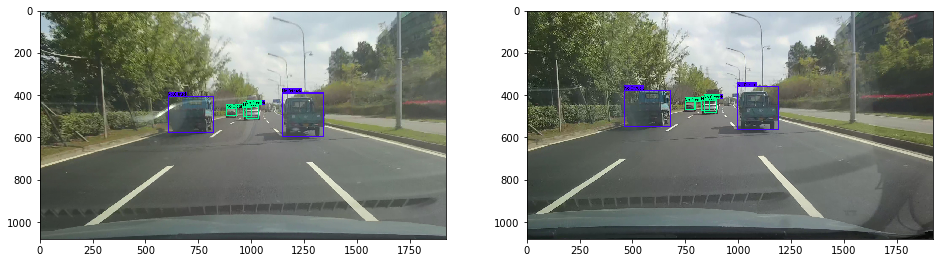

In [18]:
# Detection and Matching
h_img,w_img,_ = img_left.shape
thickness = 50
boxes,classes,scores = yolo.detect_image(img_left_pil)# detect object
idx = []
for i,box in enumerate(boxes):
    l,t,w,h = box
    # 去除位于图像边缘的目标
    if (l<thickness or t<thickness or l+w>w_img-thickness or t+h>h_img-thickness)and (w*h<thickness**2):
        continue
    else:
        idx.append(i)
boxes = [boxes[i] for i in idx]
classes = [classes[i] for i in idx]
scores = [scores[i] for i in idx]

boxes_matched = []
boxes = np.array(boxes)# easier to compute
img_left_draw = img_left_pil.copy()
img_right_draw = img_right_pil.copy()
for i,box in enumerate(boxes):
    ret,search_patch,box_matched = match_images(img_left,img_right,box,offset=(-400,-40,0,40),
                                   method = cv2.TM_CCOEFF_NORMED)# match two image
    boxes_matched.append(box_matched)
#     search_patches.append(search_patch)
#     rets.append(ret)
    
    object_id = '0'
    object_class = classes[i]
    color = yolo.colors[yolo.class_names.index(object_class)]
    # draw boxes
    box[2:] = box[2:] + box[:2]# ltwh 2 ltrb. Note boxes had been changed!!!!!
    img_left_draw = draw_box(img_left_draw,box,object_id,object_class,color,20)
    img_right_draw = draw_box(img_right_draw,box_matched,object_id,object_class,color,20)
#     print("box_r",box_matched)
    
boxes_matched = np.array(boxes_matched)

img_left_show = np.asarray(img_left_draw)
img_right_show = np.asarray(img_right_draw)
plt.figure(figsize=(16,10))
plt.subplot(121)
plt.imshow(img_left_show)
plt.subplot(122)
plt.imshow(img_right_show)

cv2.imshow('left',img_left_show[...,::-1])
cv2.imshow('right',img_right_show[...,::-1])
cv2.waitKey(0)
cv2.destroyAllWindows()

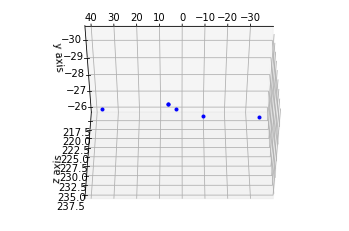

distance:
[234.7542676  227.43722424 220.28473219 236.3914957  234.7542676
 240.04332826]


In [21]:
# use the center of boxes stand for object's location
pts2D_1 = np.ones((3,len(boxes)),dtype='float')
pts2D_2 = np.ones((3,len(boxes)),dtype='float')

# boxes[:,2:] = boxes[:,2:] + boxes[:,:2]# ltwh 2 ltrb
for i in range(len(boxes)):
    pts2D_1[:2,i] = (boxes[i,:2] + boxes[i,2:])/2.
    pts2D_2[:2,i] = (boxes_matched[i,:2] + boxes_matched[i,2:])/2.

# triangulation
pts3D = structure.linear_triangulation(pts2D_1,pts2D_2,P1,P2)
# pts3D = structure.linear_triangulation(pts2D_1,pts2D_2,P2,P1)
# X朝右，Y朝上，Z朝前
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(pts3D[0], pts3D[1], pts3D[2], 'b.')
ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')
ax.view_init(elev=135, azim=90)
plt.show()
# print('2D1:')
# print(pts2D_1)
# print("2D2:")
# print(pts2D_2)
# print(pts3D[:3,:])
print("distance:")
print(np.sqrt(np.sum(pts3D[:3,:]**2,axis=0)))

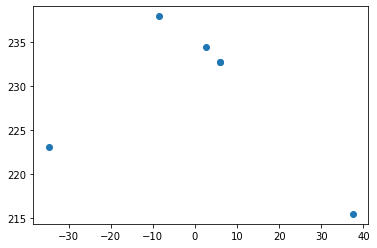

In [20]:
# 俯视图
plt.scatter(pts3D[0,:],pts3D[2,:])